In [10]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load the 2024 data
folder_path = "../data/raw/"
file_name = "ice_electric-2024final.xlsx"

# Create dataframe
df = pd.read_excel(folder_path + file_name)

# Rename the columns to be more code-friendly
df.columns = [
    "price_hub", "trade_date", "delivery_start_date", "delivery_end_date",
    "high_price", "low_price", "avg_price", "price_change",
    "daily_volume", "num_trades", "num_counterparties"
]

# Remove non-numerical column price_hub (can be useful, but we keep this exercise simple)
numeric_cols = df.select_dtypes(include='number').columns
numeric = df[numeric_cols]
trade_date = df["trade_date"]
df = pd.concat([trade_date, numeric], axis=1)

# Convert dates to datetime
df["trade_date"] = pd.to_datetime(df["trade_date"])
# Set trade date as index
df.set_index("trade_date", inplace=True)

# Sort by date (nice when plotting)
df.sort_index(inplace=True)

df.head(n=5)

,high_price,low_price,avg_price,price_change,daily_volume,num_trades,num_counterparties
trade_date,,,,,,,
2023-12-27,37.50,34.00,35.27,-0.93,9600,12,11
2023-12-27,38.50,37.50,38.00,3.00,1600,2,3
2023-12-27,30.25,30.00,30.06,-23.94,3200,4,6
2023-12-27,36.00,34.00,35.54,6.45,4800,6,4
2023-12-27,28.10,27.85,27.93,0.88,2400,3,5


In [3]:
# Lagged feature for training
df_ml = df.copy()

# Lagged price features. Lag goes from 1 to 7 days
for lag in range(1, 8): 
    df_ml[f"lag_{lag}"] = df_ml["avg_price"].shift(lag)

# Drop any NaNs induced by lagging
df_ml.dropna(inplace=True)

df_ml.head()

,high_price,low_price,avg_price,price_change,daily_volume,num_trades,num_counterparties,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
trade_date,,,,,,,,,,,,,,
2023-12-28,28.5,28.20,28.27,0.34,8800,11,10,41.08,35.00,27.93,35.54,30.06,38.00,35.27
2023-12-28,23.5,19.00,20.17,-15.37,3600,9,7,28.27,41.08,35.00,27.93,35.54,30.06,38.00
2023-12-28,30.0,29.75,29.81,-0.25,3200,4,7,20.17,28.27,41.08,35.00,27.93,35.54,30.06
2023-12-29,45.0,28.00,34.28,14.11,8000,20,15,29.81,20.17,28.27,41.08,35.00,27.93,35.54
2023-12-29,35.0,33.00,33.65,5.38,12000,14,17,34.28,29.81,20.17,28.27,41.08,35.00,27.93


In [7]:
X = df_ml.drop("avg_price", axis=1)  # Features
y = df_ml["avg_price"]  # Target, labels

# Train test split, 80% train
split_index = int(len(df_ml) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Train shape {X_train.shape}, Test shape: {X_test.shape}")

Train shape (973, 13), Test shape: (244, 13)


In [9]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predit on data
y_pred = rf_model.predict(X_test)

In [12]:
# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mean_abs_err = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mean_abs_err:.3f}")
print(f"R²: {r2:.3f}")

RMSE: 0.974
MAE: 0.542
R²: 0.997


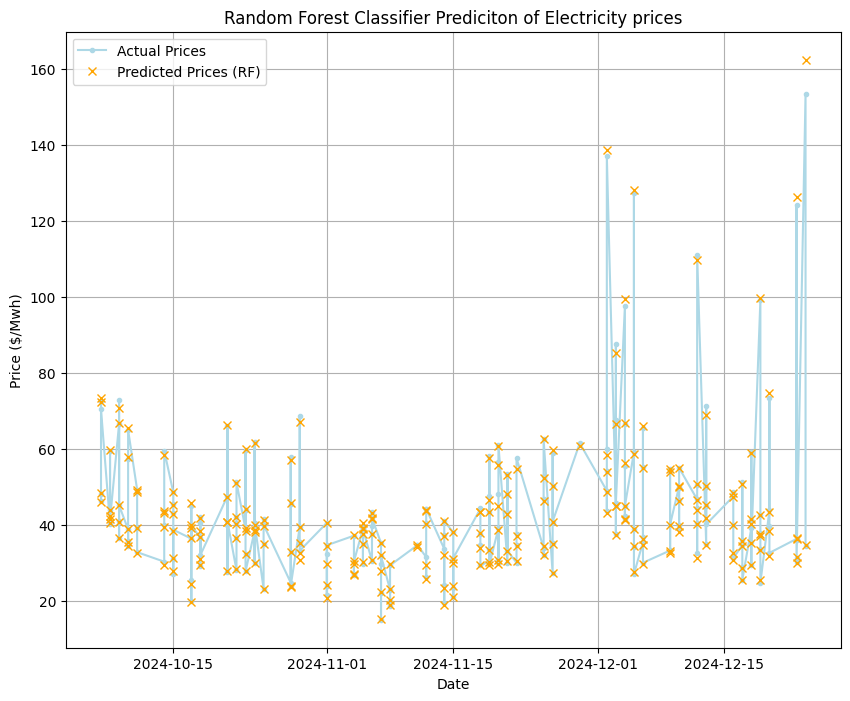

In [17]:
# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(y_test.index, y_test, label="Actual Prices", c="lightblue", marker=".", ls="-")
ax.plot(y_test.index, y_pred, label="Predicted Prices (RF)", c="orange", marker="x", ls="")
ax.set(xlabel="Date", ylabel="Price ($/Mwh)", title="Random Forest Classifier Prediciton of Electricity prices")
ax.legend()
ax.grid()
plt.show()
